# Import Library dan Load Data

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 6 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima.arima import auto_arima

In [16]:
data = pd.read_csv('TLKM.JK.csv')

In [17]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0
...,...,...,...,...,...,...,...
1417,2022-08-26,4510.0,4540.0,4480.0,4490.0,4490.000000,184317100.0
1418,2022-08-29,4370.0,4550.0,4360.0,4520.0,4520.000000,101529800.0
1419,2022-08-30,4580.0,4620.0,4480.0,4480.0,4480.000000,118884300.0
1420,2022-08-31,4420.0,4600.0,4420.0,4560.0,4560.000000,175300400.0


# Eksplorasi Data

In [18]:
type(data)

pandas.core.frame.DataFrame

In [20]:
data.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [21]:
data=data.dropna()

In [22]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0
...,...,...,...,...,...,...,...
1417,2022-08-26,4510.0,4540.0,4480.0,4490.0,4490.000000,184317100.0
1418,2022-08-29,4370.0,4550.0,4360.0,4520.0,4520.000000,101529800.0
1419,2022-08-30,4580.0,4620.0,4480.0,4480.0,4480.000000,118884300.0
1420,2022-08-31,4420.0,4600.0,4420.0,4560.0,4560.000000,175300400.0


In [23]:
data = data.drop(['Open','Low','Close','Adj Close','Volume'],axis='columns')

In [24]:
print(data.dtypes)

Date     object
High    float64
dtype: object


In [25]:
data

,Date,High
0,2017-01-02,3980.0
1,2017-01-03,3990.0
2,2017-01-04,3980.0
3,2017-01-05,4030.0
4,2017-01-06,4010.0
...,...,...
1417,2022-08-26,4540.0
1418,2022-08-29,4550.0
1419,2022-08-30,4620.0
1420,2022-08-31,4600.0


In [27]:
#Mengubah tanggal menjadi index
con = data['Date']
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2022-08-19', '2022-08-22', '2022-08-23', '2022-08-24',
               '2022-08-25', '2022-08-26', '2022-08-29', '2022-08-30',
               '2022-08-31', '2022-09-01'],
              dtype='datetime64[ns]', name='Date', length=1421, freq=None)

In [35]:
#Menginisialkan variabel High sebagai data time series
ts = data['High']
ts.head(10)

Date
2017-01-02    3980.0
2017-01-03    3990.0
2017-01-04    3980.0
2017-01-05    4030.0
2017-01-06    4010.0
2017-01-09    4030.0
2017-01-10    4030.0
2017-01-11    4000.0
2017-01-12    3970.0
2017-01-13    3970.0
Name: High, dtype: float64

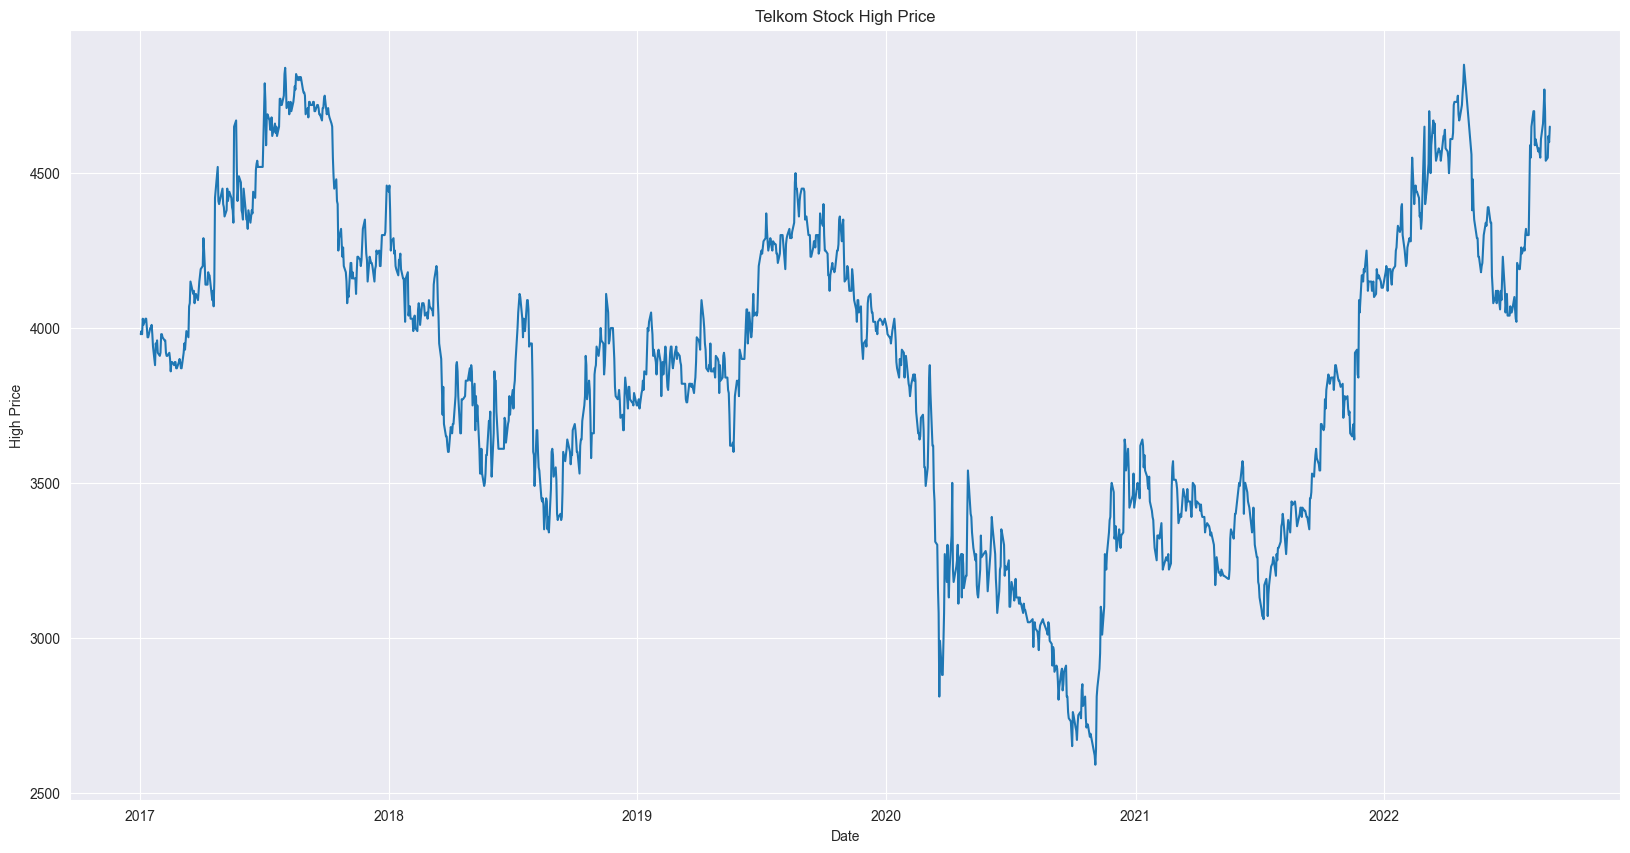

In [36]:
#Visualisasi dataset
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title('Telkom Stock High Price')
plt.plot(data['High'])

## Uji Stasioneritas Data

In [37]:
#Deklarasi fungsi untuk mengecek stasioneritas data
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Uji Hipotesis:

H0 : Data tidak stasioner

Ha : Data stasioner

Tolak H0 apabila diperoleh p-value < alpha (0,05)

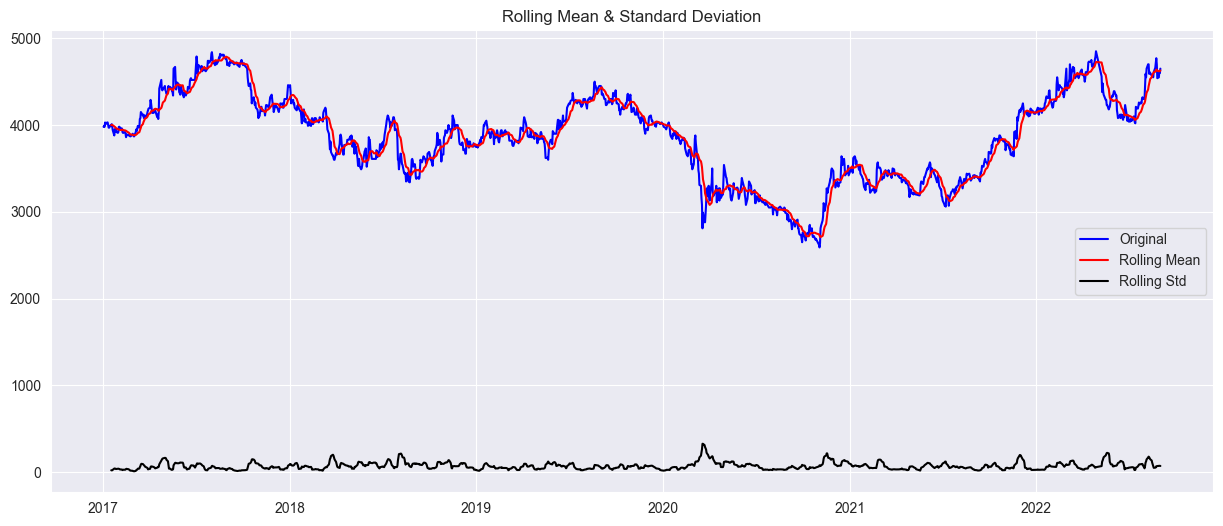

Results of Dickey-Fuller Test:
Test Statistic                   -1.775556
p-value                           0.392663
#Lags Used                        2.000000
Number of Observations Used    1418.000000
Critical Value (1%)              -3.434970
Critical Value (5%)              -2.863580
Critical Value (10%)             -2.567856
dtype: float64


In [38]:
#Melakukan uji stasioneritas untuk dataset
test_stationarity(ts)

Diperoleh nilai p-value > 0,05, maka H0 tidak ditolak.

Jadi, data memiliki keadaan yang tidak stasioner.

Karena data belum stasioner, sehingga perlu dilakukan proses stasionerisasi data, yakni dengan proses differencing untuk memperoleh data yang stasioner.

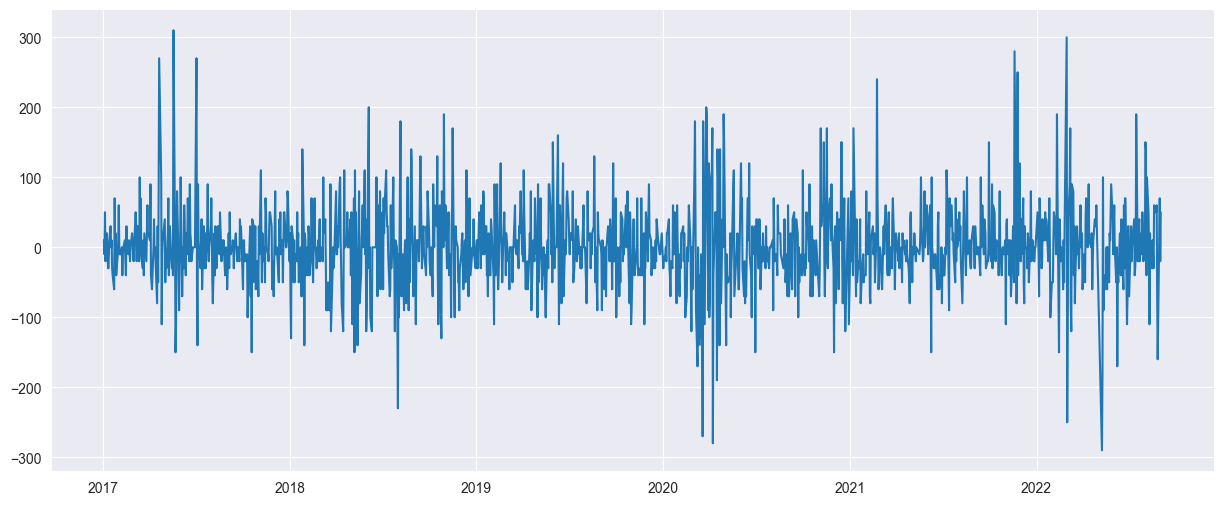

In [118]:
ts_diff_1 = ts - ts.shift()
ts_diff_1 = ts_diff_1.dropna()
plt.plot(ts_diff_1)

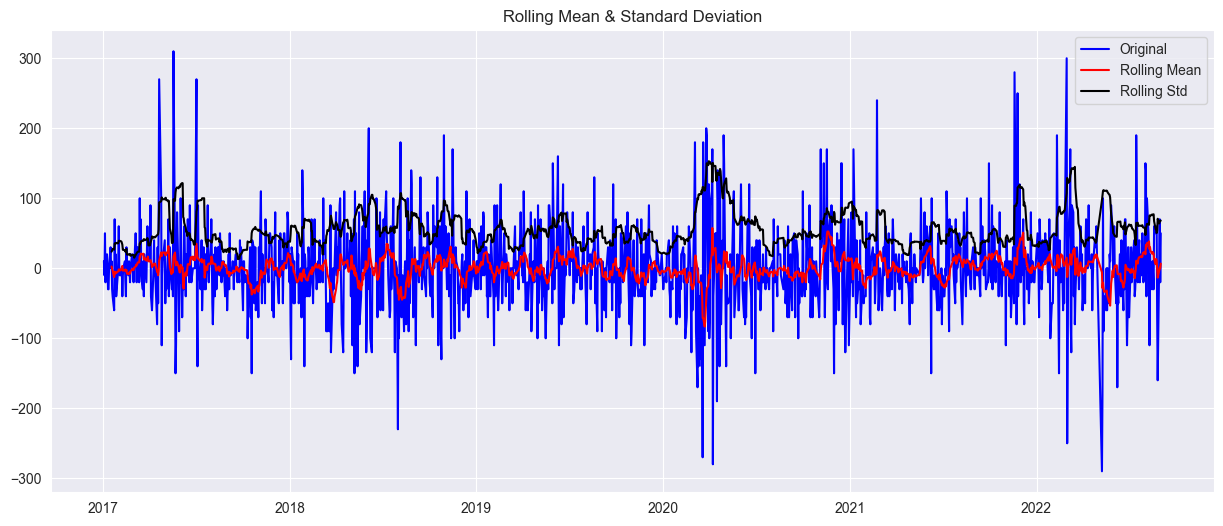

Results of Dickey-Fuller Test:
Test Statistic                  -29.891562
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1418.000000
Critical Value (1%)              -3.434970
Critical Value (5%)              -2.863580
Critical Value (10%)             -2.567856
dtype: float64


In [119]:
test_stationarity(ts_diff_1)

Setelah dilakukan proses differencing dan diuji stasioneritas data (setelah differencing), diperoleh data setelah differencing 1x telah membentuk data yang stasioner.

In [121]:
#Mencari best model terbaik secara otomatis yang akan digunakan nantinya
modell = auto_arima(ts,                       #data training yang akan dimodelkan
                      start_p=0,                #awal orde PACF yang dicek
                      start_q=0,                #awal orde ACF yang dicek
                      test='adf',
                      max_p=None,
                      max_q=None,
                      m=1,                      #menunjukkan period setiap season, karena tidak seasonal maka m=1
                      d=None,                   #tidak melalui proses differencing
                      seasonal=False,           #tidak terdapat pola seasonal
                      method = 'bfgs',          #metode dalam mengoptimasi parameter, bfgs = broyden-fletcher-goldfarb-shanno
                      trace=True,               #mencetak beberapa status dari fits
                      error_action='ignore',    #error-handling
                      suppress_warnings=True,   #mematikan semua peringatan
                   )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15666.379, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15668.373, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15668.372, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15664.466, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15663.788, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15652.669, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15650.731, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15652.655, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15654.655, Time=0.96 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=15648.841, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15666.461, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=15650.765, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15650.780, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15661.921, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0

PENCARIAN MODEL TERBAIK BERDASARKAN NILAI RMSE

In [89]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [93]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(ts.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=497.556
ARIMA(0, 0, 1) RMSE=269.975
ARIMA(0, 0, 2) RMSE=173.330
ARIMA(0, 1, 0) RMSE=61.292
ARIMA(0, 1, 1) RMSE=61.394
ARIMA(0, 1, 2) RMSE=60.658
ARIMA(0, 2, 0) RMSE=88.091
ARIMA(0, 2, 1) RMSE=61.329
ARIMA(0, 2, 2) RMSE=61.418
ARIMA(1, 0, 0) RMSE=61.299
ARIMA(1, 0, 1) RMSE=61.405
ARIMA(1, 0, 2) RMSE=60.694
ARIMA(1, 1, 0) RMSE=61.373
ARIMA(1, 1, 1) RMSE=61.600
ARIMA(1, 1, 2) RMSE=60.781
ARIMA(1, 2, 0) RMSE=79.616
ARIMA(1, 2, 1) RMSE=61.397
ARIMA(1, 2, 2) RMSE=61.178
ARIMA(2, 0, 0) RMSE=61.383
ARIMA(2, 0, 1) RMSE=61.277
ARIMA(2, 0, 2) RMSE=60.803
ARIMA(2, 1, 0) RMSE=60.609
ARIMA(2, 1, 1) RMSE=60.742
ARIMA(2, 1, 2) RMSE=60.780
ARIMA(2, 2, 0) RMSE=71.422
ARIMA(2, 2, 1) RMSE=60.648
ARIMA(2, 2, 2) RMSE=61.243
Best ARIMA(2, 1, 0) RMSE=60.609


Setelah dilakukan percobaan dengan model ARIMA(p,d,q) dengan:

- orde p = 0 dan 1
- orde d = 0 dan 1
- orde q = 0 dan 1

Diperoleh model yang menghasilkan RMSE terkecil adalah model ARIMA (2,1,0).

Hal ini sama dengan pengecekan model arima otomatis menggunakan fungsi auto_arima sebelumnya.

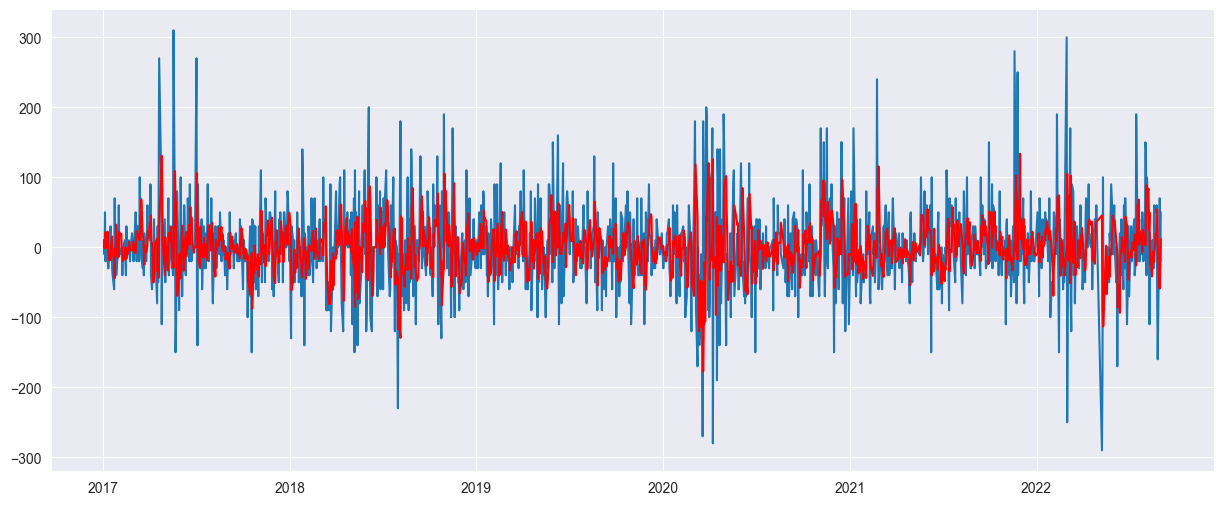

In [104]:
#Visualisasi perbandingan antara dataset setelah differencing dengan data hasil prediksi ARIMA(2,1,0)
model_ARIMA = ARIMA(ts_diff_1, order=(2,1,0))
results_ARIMA = model_ARIMA.fit()
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_diff_1)             
plt.plot(predictions_ARIMA, color='red')  

# Prediksi Data

In [117]:
#Prediksi data dengan model ARIMA(2,1,0) untuk 2 hari ke depan
predict_dif = results_ARIMA.predict(start=1422,end=1423)
predictions_dif_cum_sum = predict_dif.cumsum()                   #prediksi differencingnya
pred_ts = [ts[-1]]
for i, j in enumerate(predictions_dif_cum_sum):                  #prediksi data aslinya
  a = pred_ts[i] + j
  pred_ts.append(a)
predict = pd.Series(pred_ts[1:], index=predict_dif.index)
print(predict)

1422    4686.418425
1423    4757.630250
dtype: float64


Diperoleh hasil prediksi untuk nilai harga tertinggi saham Telkom pada periode tanggal :
- 02 September 2022 = 4686.41..
- 03 September 2022 = 4757.63..
